# Validation

gmm model is loading
12100.0 brain size


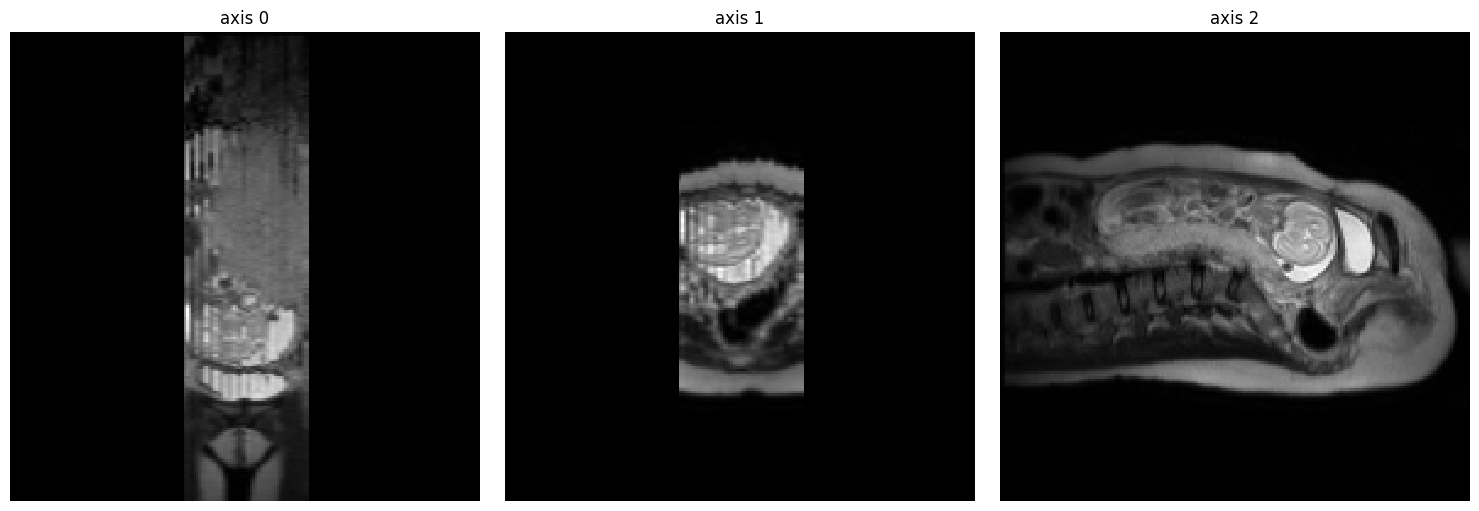

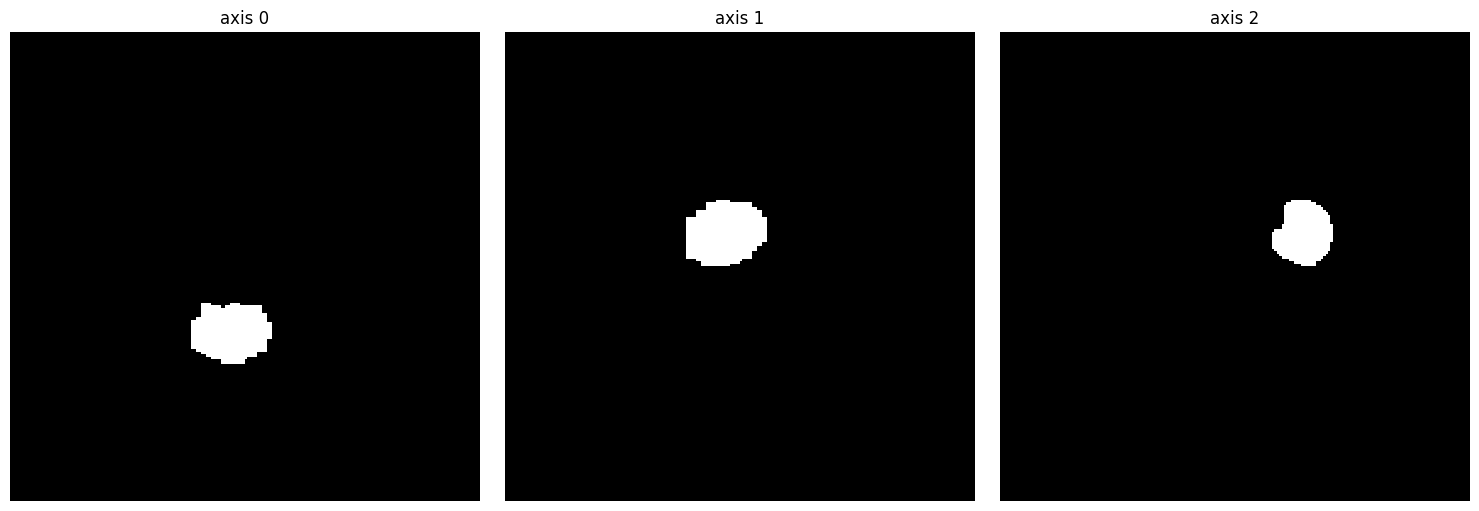

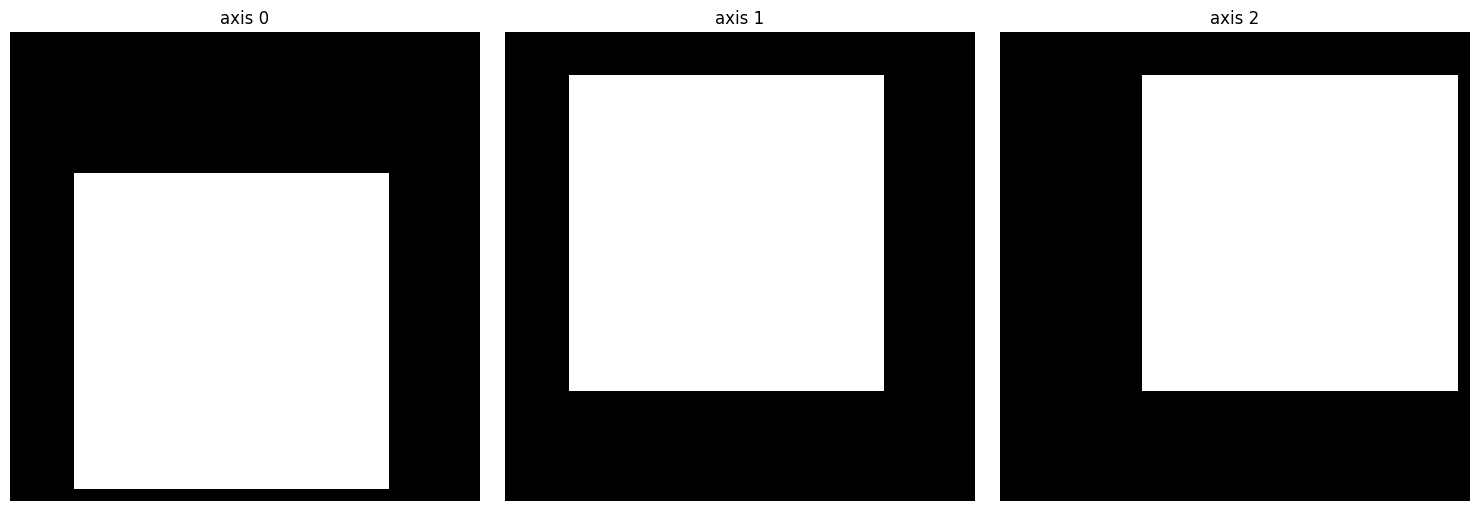

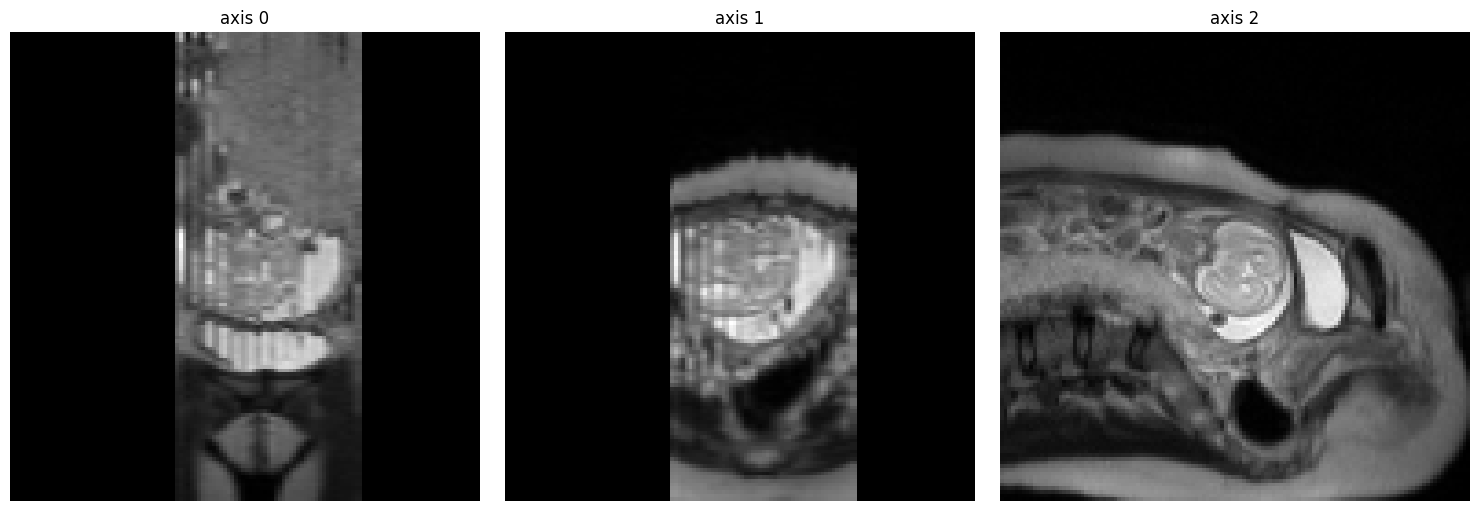

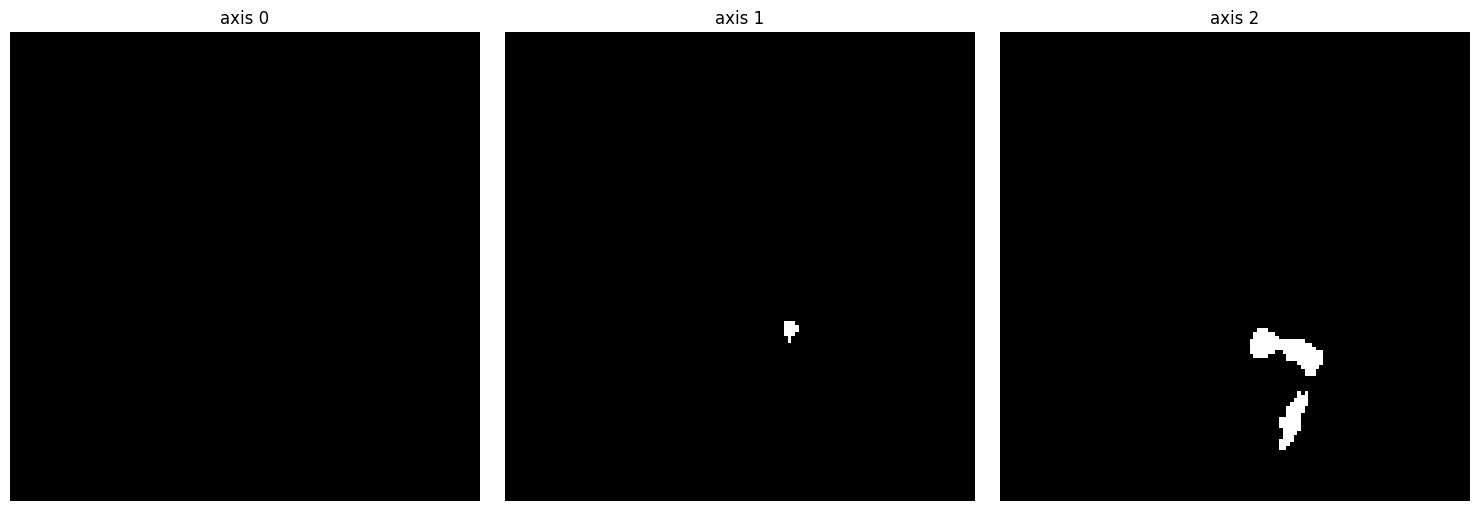

In [2]:
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
from help import *

import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

validation_folder_path="validation"
models=["6Net","12Net","24Net","48Net","gmm"]
model=models[4]

random=False
full_random=True

images, masks , b2_images, b3_images, b2_masks, b3_masks = load_val(validation_folder_path) 
image_index = 8
img = images[image_index]
mask=masks[image_index]
   
cube , box, combined_model = get_cube_and_model(model,img, mask,random, full_random) 

cube=cube[None,...,None]
prediction_one_hot = combined_model.predict(cube, verbose=0)
prediction = np.argmax(prediction_one_hot,axis=-1)
# prediction = find_largest_component(prediction[0])

print(np.sum(mask),"brain size")
mean_slice_numbers = tuple(np.median(indices) for indices in np.where(mask != 0))
ne.plot.volume3D(img,slice_nos=mean_slice_numbers);
ne.plot.volume3D(mask,slice_nos=mean_slice_numbers);
mean_slice_numbers = tuple(np.median(indices) for indices in np.where(box != 0))
ne.plot.volume3D(box,slice_nos=mean_slice_numbers);
ne.plot.volume3D(cube);
ne.plot.volume3D(prediction);

    


# Cascade Brain Identification

48Net model is loading
34038
128 128 128


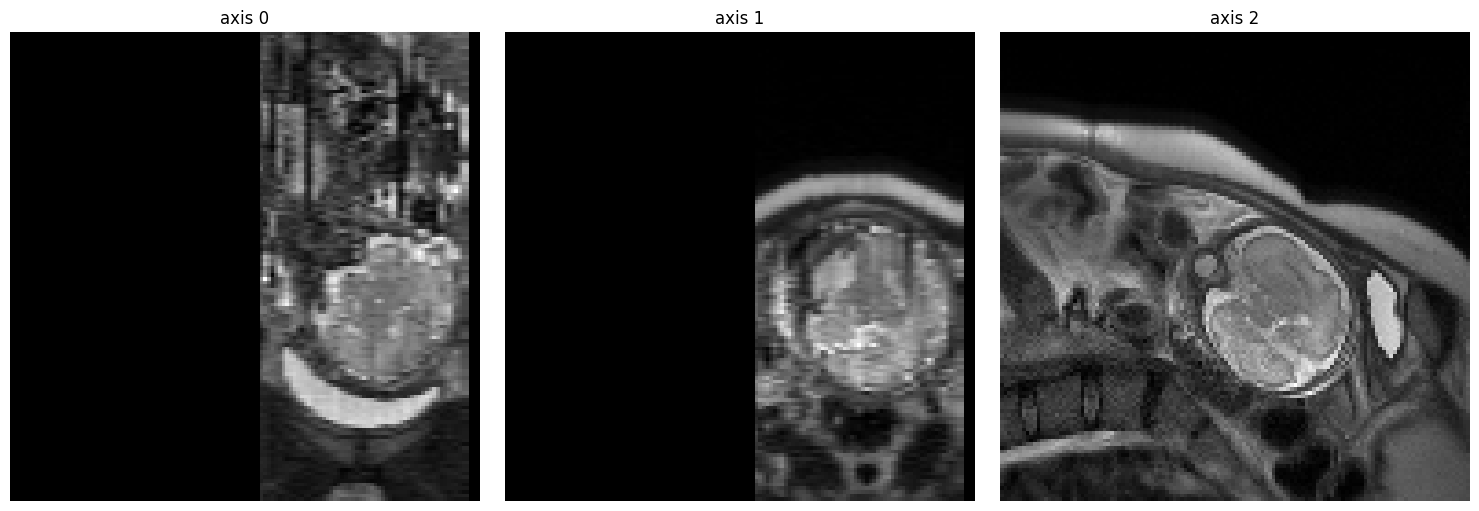

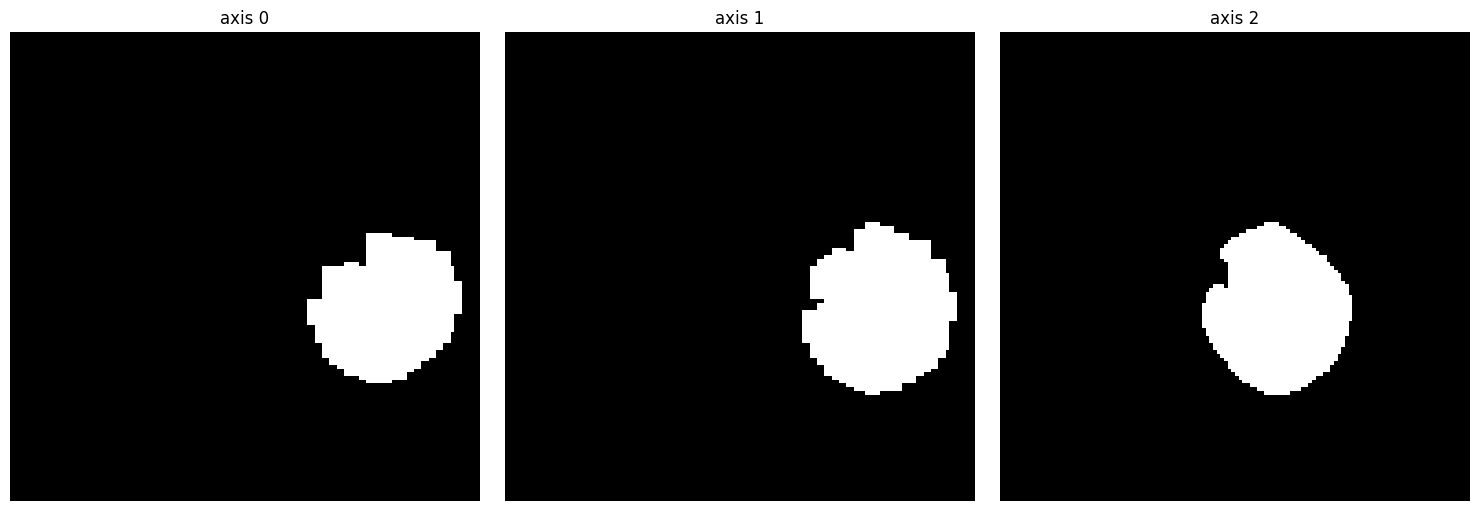

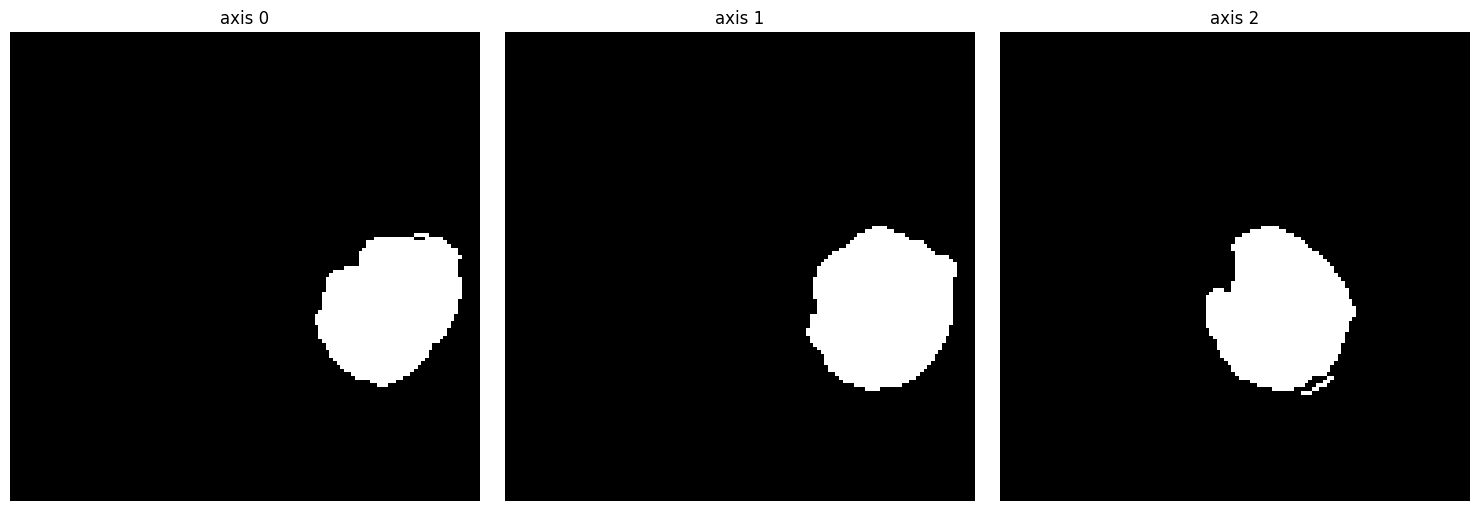

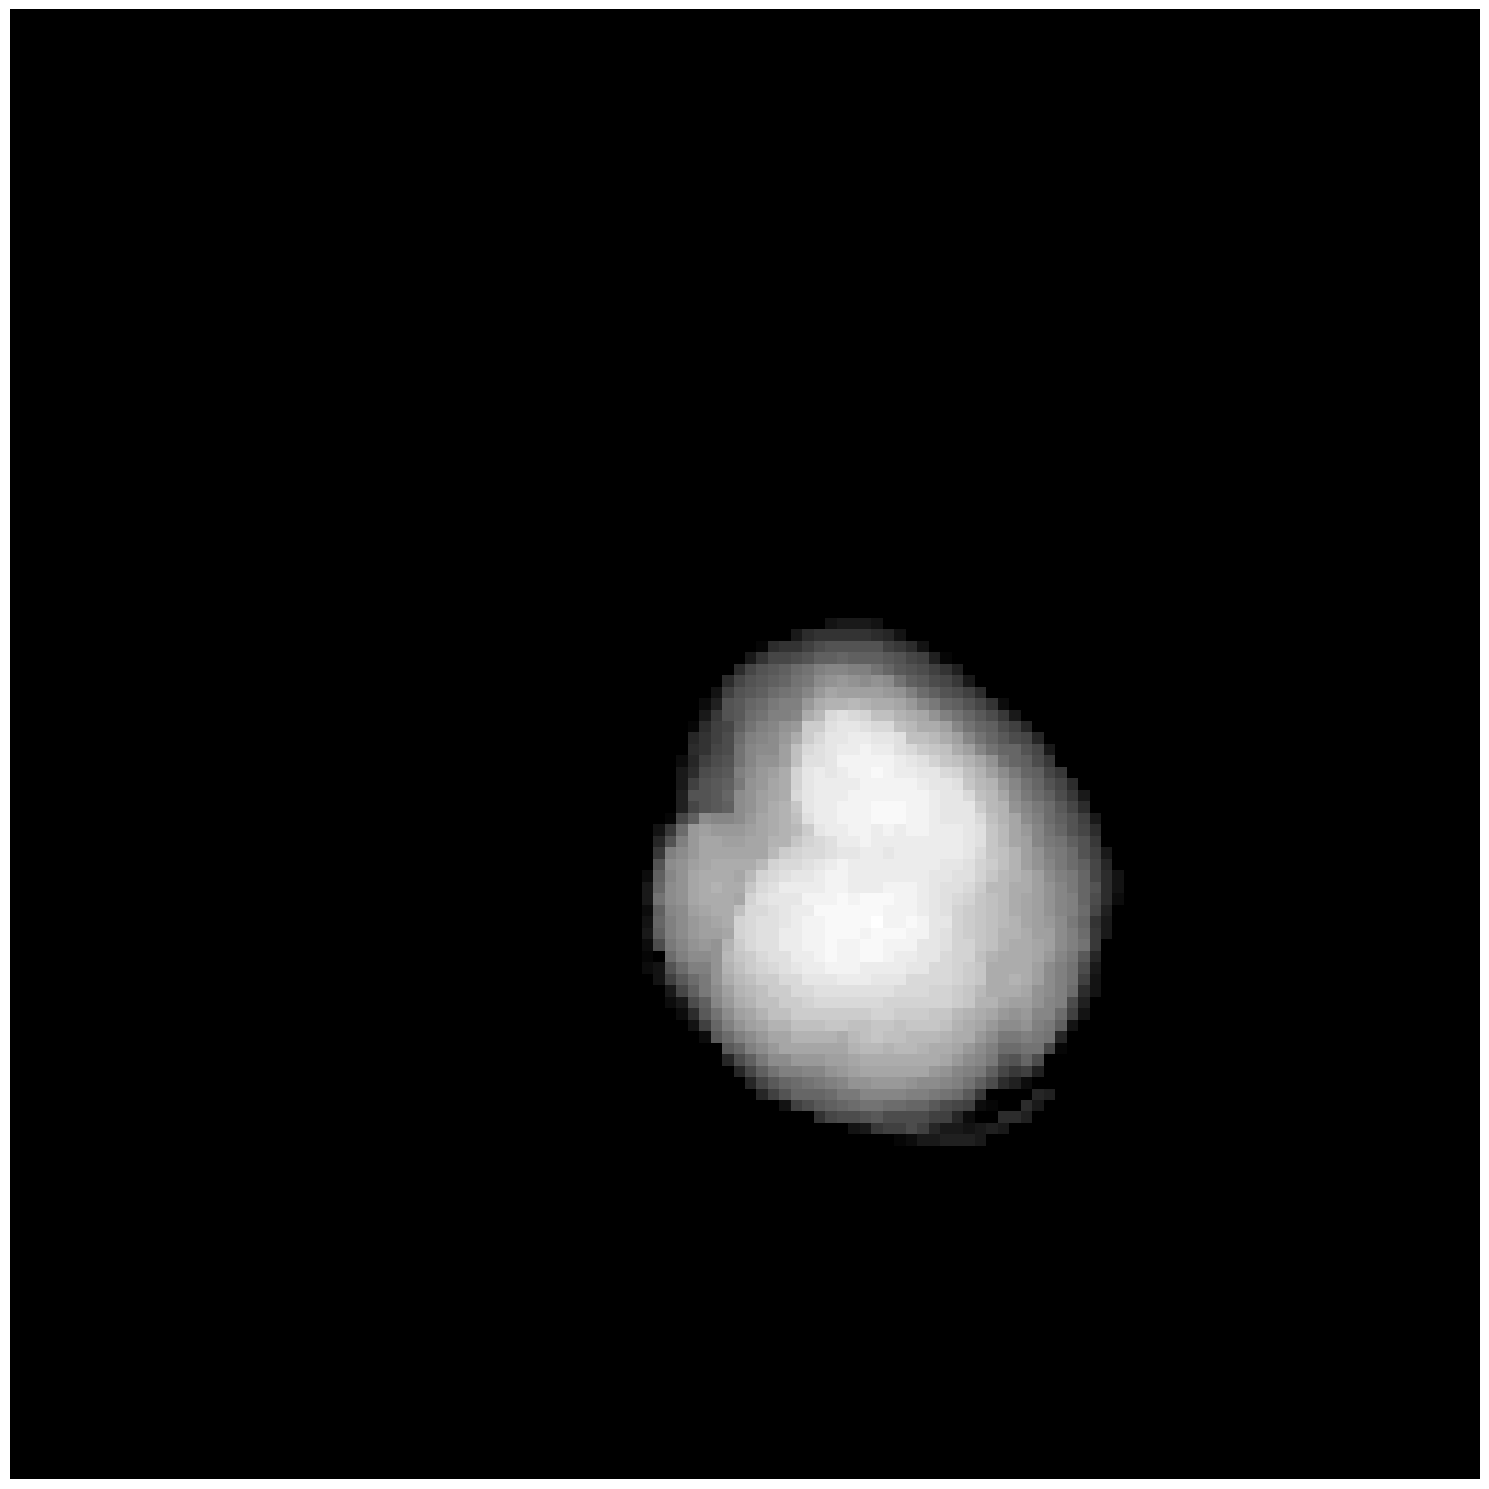

In [65]:

def is_centered_in_plane(prediction, margins=(8, 8, 8, 8)):
    summed_projection_axis2 = np.sum(prediction, axis=2)
    
    summed_projection_axis0 = np.sum(summed_projection_axis2, axis=0)
    summed_projection_axis1 = np.sum(summed_projection_axis2, axis=1)
    
    non_zero_coords_axis0 = np.argwhere(summed_projection_axis0)
    non_zero_coords_axis1 = np.argwhere(summed_projection_axis1)
    
    min_coords_axis0 = np.min(non_zero_coords_axis0, axis=0)
    max_coords_axis0 = np.max(non_zero_coords_axis0, axis=0)
    
    min_coords_axis1 = np.min(non_zero_coords_axis1, axis=0)
    max_coords_axis1 = np.max(non_zero_coords_axis1, axis=0)
    
    axis0_centered = np.all(min_coords_axis0 >= margins[0]) and np.all(summed_projection_axis0.shape - max_coords_axis0 - 1 >= margins[1])
    axis1_centered = np.all(min_coords_axis1 >= margins[2]) and np.all(summed_projection_axis1.shape - max_coords_axis1 - 1 >= margins[3])
    
    return axis0_centered and axis1_centered


positions_48, indices_48 = generate_position_map((192,192,192), param_3d.img_size_48, 8)
model=models[3]
image_index = 7
img = images[image_index]
mask=masks[image_index]
number_of_valid = 0 
# min_size=7016
min_size=9000
max_size=52278
cube , box, combined_model = get_cube_and_model(model,img, mask,random, full_random) 
valid_position_index_48=None
# cube_48 = None
for i in range(len(positions_48)):
    x1, y1, z1, x2, y2, z2 = positions_48[i]
    cube = extract_cube(img.data,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_48 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    prediction = find_largest_component(prediction[0])
    non_zero_count = np.count_nonzero(prediction)
    if  min_size <= non_zero_count and is_centered_in_plane(prediction,margins=(5, 30, 7, 7)):# <= max_size:# and is_centered_in_plane(prediction,margin=1):

        print(non_zero_count)
        print(x2-x1,y2-y1,z2-z1)
        cube_48 = extract_cube(img.data, x1, y1, z1, x2, y2, z2 ,cube_size=param_3d.img_size_48 )
        mask_48 = extract_cube(mask.data,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_48 )
        valid_position_index_192 = (x1, y1, z1, x2, y2, z2)

        ms = np.mean(np.column_stack(np.nonzero(mask_48)), axis=0).astype(int)
        ne.plot.volume3D(cube_48,slice_nos=ms);
        ne.plot.volume3D(mask_48,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        summed_projection_axis2 = np.sum(prediction, axis=2)
        ne.plot.slices(summed_projection_axis2, cmaps=['gray'])

        # ne.plot.slices(cube_48[:,:,57], cmaps=['gray'])

        break

    

In [54]:
def get_margins(input_array):
    non_zero_coords = np.argwhere(input_array)
    
    if non_zero_coords.size == 0:
        return (0, 0, 0, 0)  # If there are no non-zero elements, return 0 margins
    
    min_x = np.min(non_zero_coords[:, 1])
    max_x = np.max(non_zero_coords[:, 1])
    min_y = np.min(non_zero_coords[:, 0])
    max_y = np.max(non_zero_coords[:, 0])
    
    left_margin = min_x
    right_margin = input_array.shape[1] - max_x - 1
    top_margin = min_y
    bottom_margin = input_array.shape[0] - max_y - 1
    
    return left_margin, right_margin, top_margin, bottom_margin
print(summed_projection_axis2.shape,get_margins(summed_projection_axis2))

(128, 128) (23, 55, 6, 90)


24Net model is loading
5930


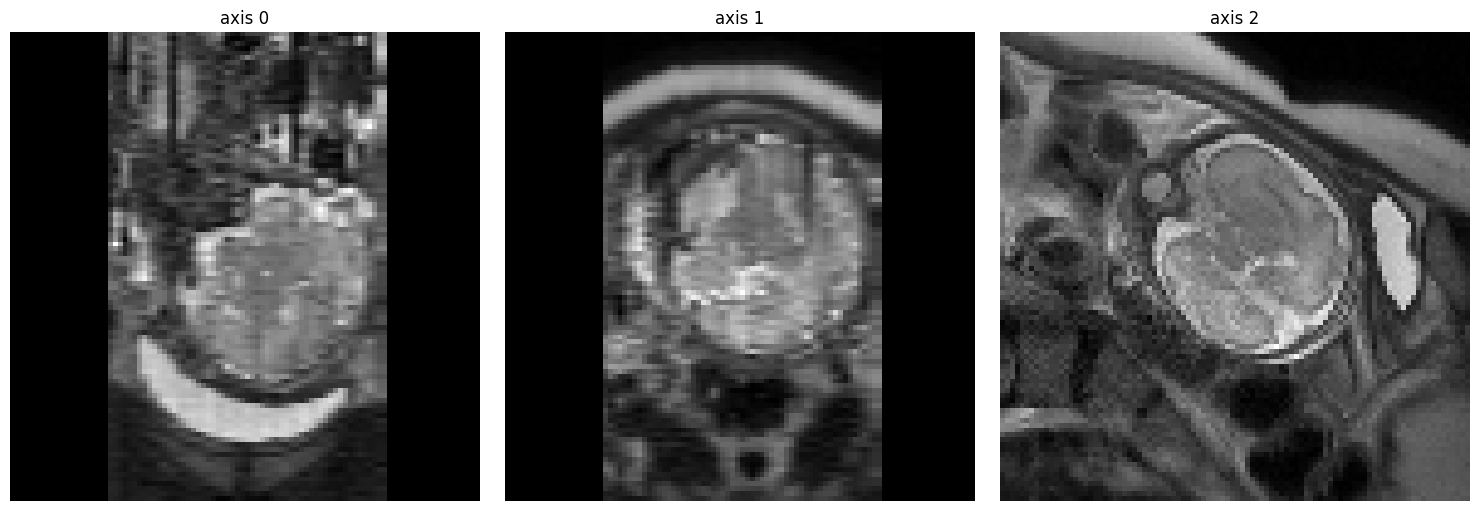

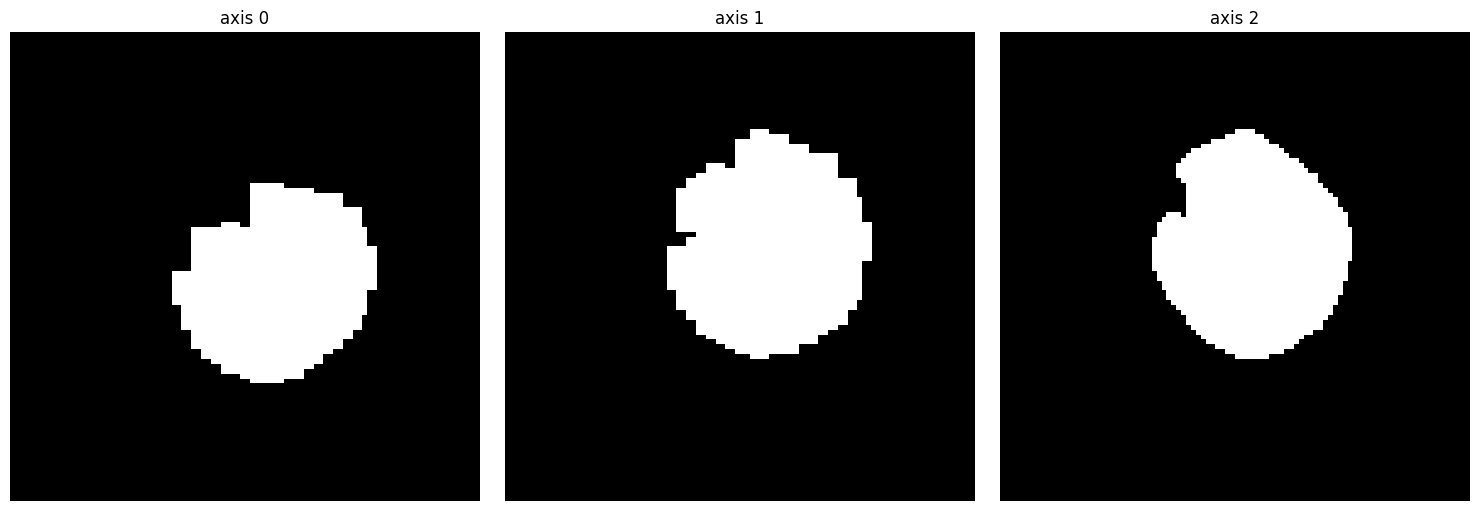

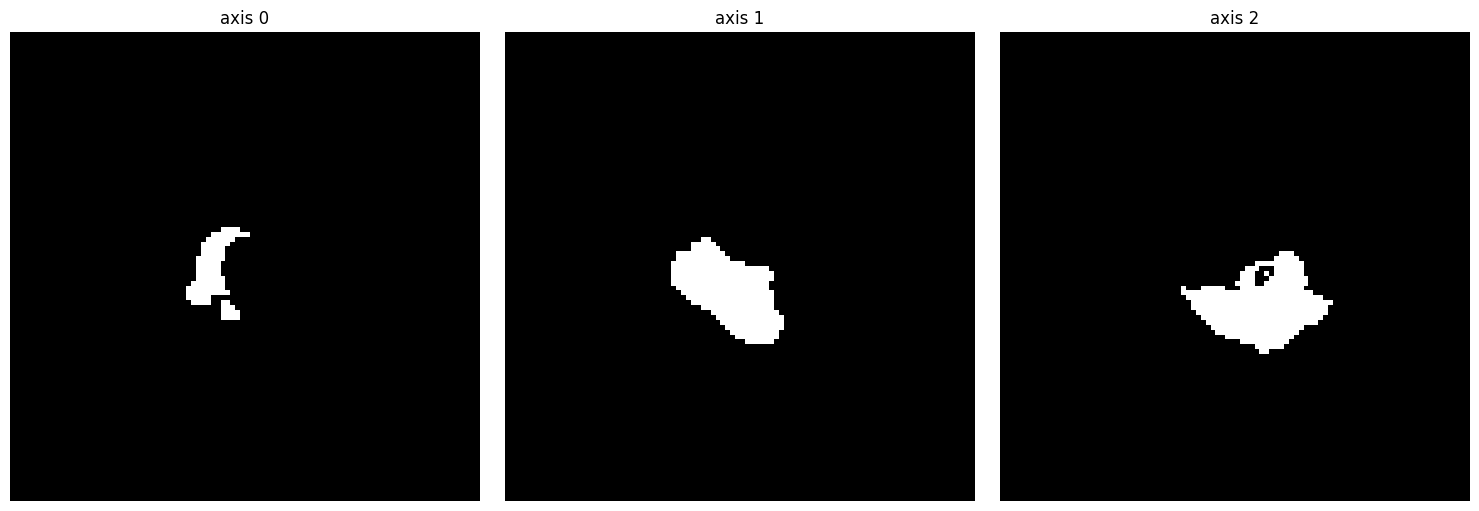

found a position! (96, 96, 96)


In [237]:
positions_24, indices_24 = generate_position_map((param_3d.img_size_48,)*3, param_3d.img_size_24, 8)
model=models[2]
min_size=5000
combined_model = get_model(model) 
valid_position_index_24=None
cube_12 = None
for i in range(len(positions_24)):
    x1, y1, z1, x2, y2, z2 = positions_24[i]
    cube = extract_cube(cube_48,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_24 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    # ne.plot.volume3D(prediction);
    prediction = find_largest_component(prediction[0])

    non_zero_count = np.count_nonzero(prediction)
    if min_size <= non_zero_count<= max_size and is_centered_in_plane(prediction,margin=8):
        print(non_zero_count)
        number_of_valid += 1
        cube_24 = extract_cube(cube_48,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_24 )
        mask_24 = extract_cube(mask_48,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_24 )
        valid_position_index_48 = (x1, y1, z1, x2, y2, z2)
        ms = np.mean(np.column_stack(np.nonzero(mask_24)), axis=0).astype(int)
        ne.plot.volume3D(cube_24,slice_nos=ms);
        ne.plot.volume3D(mask_24,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);

        print("found a position!",cube[0,...,0].shape)

        break

12Net model is loading
51230


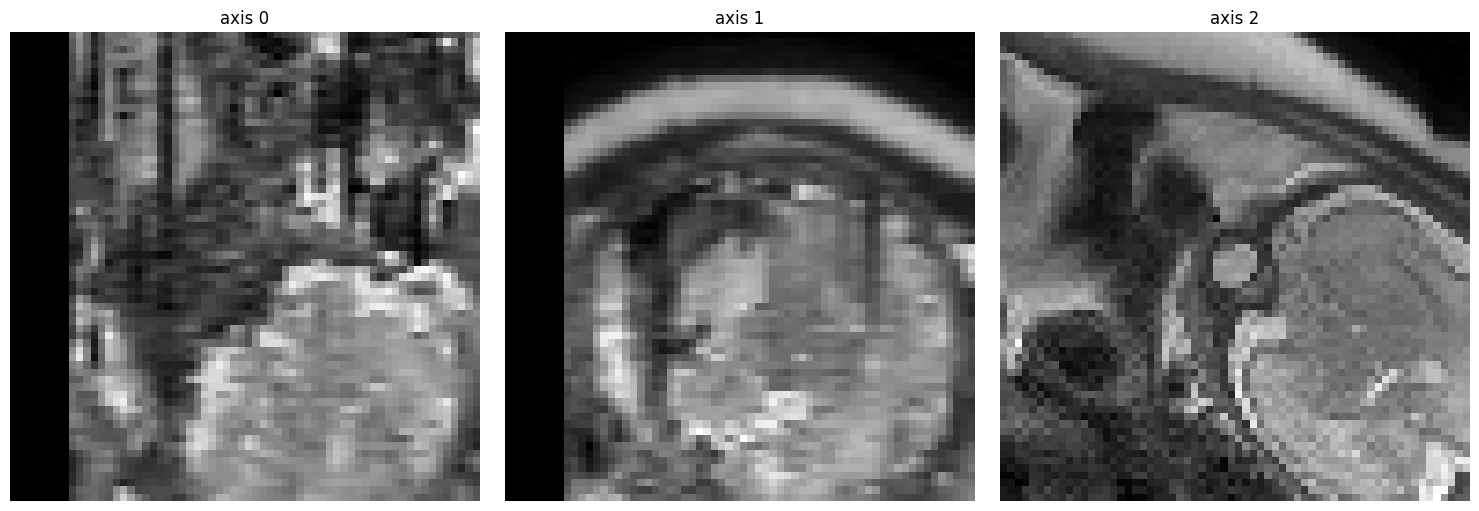

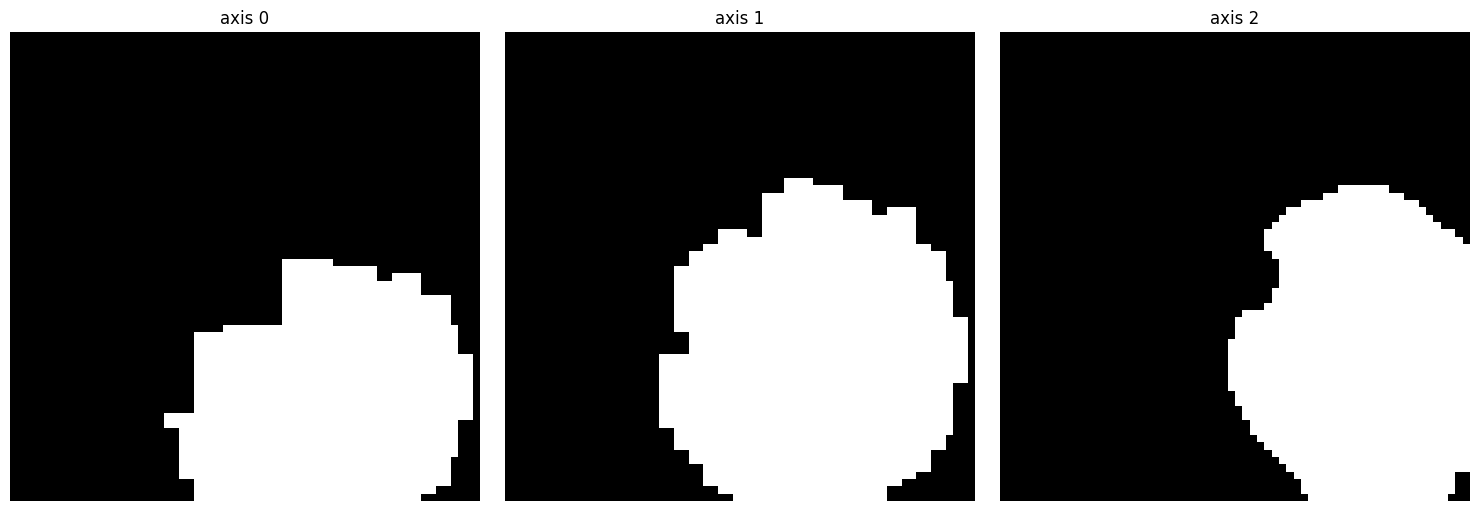

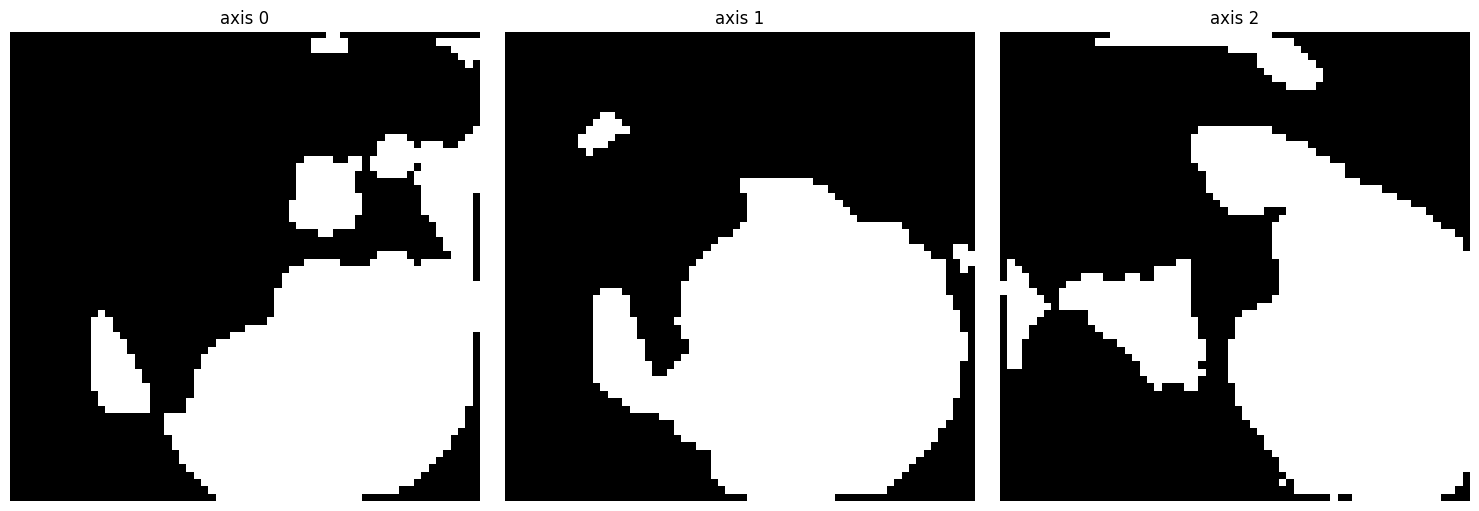

prediction mean coordinates [34 32 35]
found a position! (64, 64, 64)


In [270]:
from scipy.ndimage import label, find_objects
from scipy.ndimage import center_of_mass

positions_12, indices_12 = generate_position_map((param_3d.img_size_24,)*3, param_3d.img_size_12, 4)
model=models[1]
min_size=40000
combined_model = get_model(model) 
# valid_position_index_24=None
# cube_12 = None

    
for i in range(len(positions_12)):
    x1, y1, z1, x2, y2, z2 = positions_12[i]
    cube = extract_cube(cube_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    # ne.plot.volume3D(prediction);
    prediction = find_largest_component(prediction[0])

    non_zero_count = np.count_nonzero(prediction)
    if min_size <= non_zero_count<= max_size and is_centered_in_plane(prediction,margin=0):

        print(non_zero_count)
        number_of_valid += 1
        cube_12 = extract_cube(cube_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
        mask_12 = extract_cube(mask_24,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_12 )
        
        ms = np.mean(np.column_stack(np.nonzero(mask_12)), axis=0).astype(int)
        ne.plot.volume3D(cube_12,slice_nos=ms);
        ne.plot.volume3D(mask_12,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        # ms2 = np.mean(np.column_stack(np.nonzero(prediction)), axis=0).astype(int)
        print("prediction mean coordinates",ms2)
        print("found a position!",cube[0,...,0].shape)

        break

In [280]:
from scipy.ndimage import label, find_objects
from scipy.ndimage import center_of_mass

positions_6, indices_6 = generate_position_map((param_3d.img_size_12,)*3, param_3d.img_size_6, 8)
model=models[0]
min_size=30000
combined_model = get_model(model) 
# valid_position_index_24=None
# cube_12 = None

    
for i in range(len(positions_6)):
    x1, y1, z1, x2, y2, z2 = positions_6[i]
    cube = extract_cube(cube_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
    cube=cube[None,...,None]
    prediction_one_hot = combined_model.predict(cube, verbose=0)
    prediction = np.argmax(prediction_one_hot,axis=-1)
    # ne.plot.volume3D(prediction);
    prediction = find_largest_component(prediction[0])

    non_zero_count = np.count_nonzero(prediction)
    if min_size <= non_zero_count<= max_size and is_centered_in_plane(prediction,margin=0):

        print(non_zero_count)
        number_of_valid += 1
        cube_6 = extract_cube(cube_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
        mask_6 = extract_cube(mask_12,x1, y1, z1, x2, y2, z2,cube_size=param_3d.img_size_6 )
        ms = np.mean(np.column_stack(np.nonzero(mask_6)), axis=0).astype(int)

        ne.plot.volume3D(cube_6,slice_nos=ms);
        ne.plot.volume3D(mask_6,slice_nos=ms);
        ne.plot.volume3D(prediction,slice_nos=ms);
        # ms2 = np.mean(np.column_stack(np.nonzero(prediction)), axis=0).astype(int)
        print("prediction mean coordinates",ms2)
        print("found a position!",cube[0,...,0].shape)

        break

6Net model is loading


In [279]:
np.sum(mask_12)

33571.0

In [57]:
min_size

100

In [80]:
cube.shape

(1, 64, 64, 64, 1)